In [1]:
import sys, os, time, gc, click, logging, pprint
from os.path import expanduser
from collections import defaultdict
import numpy as np
from mpi4py import MPI
import neuroh5
from neuroh5.io import append_cell_attributes, read_population_ranges, bcast_cell_attributes, \
    scatter_read_cell_attributes, read_cell_attribute_selection, NeuroH5ProjectionGen
import h5py
import matplotlib.pyplot as plt


In [2]:
user_home = expanduser("~")
neuron_home = '%s/bin/nrnpython3/lib/python' % user_home
model_home = '%s/src/model' % user_home
dentate_home = '%s/dentate' % model_home
sys.path.append(neuron_home) 
sys.path.append(model_home) 

import dentate
from dentate.env import Env
from dentate import utils, stimulus, synapses
from dentate.utils import *

In [3]:
template_paths='%s/templates' % dentate_home
dataset_prefix='%s/datasets' % dentate_home
config_prefix='%s/config' % dentate_home


In [4]:
synapse_name='AMPA'
config_file='Network_Clamp_GC_Exc_Sat_SLN_IN_Izh_proximal_pf.yaml'
output_weights_namespace='Structured Weights'
h5types_path=f'{dataset_prefix}/dentate_h5types.h5'
connections_path=f'{dataset_prefix}/Slice/dentatenet_Slice_SLN_proximal_pf_20210924.h5'
input_features_path=f'{dataset_prefix}/Full_Scale_Control/DG_input_features_20200910_compressed.h5'
initial_weights_namespace="Log-Normal Weights"  
initial_weights_path=f'{dataset_prefix}/Slice/dentatenet_Slice_SLN_proximal_pf_20210924.h5'
non_structured_weights_namespace="Normal Weights"  
non_structured_weights_path=f'{dataset_prefix}/Slice/dentatenet_Slice_SLN_proximal_pf_20210924.h5'

arena_id='A' 
use_arena_margin=True
coordinates=(None, None) 
optimize_tol=1e-3
optimize_grad=True
max_delta_weight=10
field_width_scale = 1.25
target_amplitude=10.0
initial_weight_decay_fraction=0.5


In [5]:
np.seterr(all='raise')
os.chdir(dentate_home)
env = Env(config_prefix=config_prefix,config_file=config_file,template_paths=template_paths,dataset_prefix=dataset_prefix)


In [6]:
def get_input_arrays(structured_weights_dict, gid):

    target_map = structured_weights_dict[gid]['target_map']
    initial_weight_dict = structured_weights_dict[gid]['initial_weight_dict']
    input_rate_map_dict = structured_weights_dict[gid]['input_rate_map_dict']
    non_structured_input_rate_map_dict = structured_weights_dict[gid]['non_structured_input_rate_map_dict']
    non_structured_weights_dict = structured_weights_dict[gid]['non_structured_weight_dict']
    syn_count_dict = structured_weights_dict[gid]['syn_count_dict']
    arena_x = structured_weights_dict[gid]['arena_x']
    arena_y = structured_weights_dict[gid]['arena_y']

    input_matrix = np.empty((target_map.size, len(input_rate_map_dict)),
                            dtype=np.float64)
    source_gid_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
    syn_count_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
    initial_weight_array = np.empty(len(input_rate_map_dict), dtype=np.float64)
    for i, source_gid in enumerate(input_rate_map_dict):
        source_gid_array[i] = source_gid
        this_syn_count = syn_count_dict[source_gid]
        this_input = input_rate_map_dict[source_gid].ravel() * this_syn_count
        input_matrix[:, i] = this_input
        syn_count_array[i] = this_syn_count
        initial_weight_array[i] = initial_weight_dict[source_gid]


    non_structured_input_matrix = None
    if non_structured_input_rate_map_dict is not None:
        non_structured_input_matrix = np.empty((target_map.size, len(non_structured_input_rate_map_dict)),
                                    dtype=np.float32)
        non_structured_weight_array = np.empty(len(non_structured_input_rate_map_dict), dtype=np.float32)
        for i, source_gid in enumerate(non_structured_input_rate_map_dict):
            this_syn_count = syn_count_dict[source_gid]
            this_input = non_structured_input_rate_map_dict[source_gid].ravel() * this_syn_count
            non_structured_input_matrix[:, i] = this_input
            non_structured_weight_array[i] = non_structured_weights_dict.get(source_gid, 1.0)

    return {'target_map': target_map,
            'input_matrix': input_matrix, 
            'initial_weight_array': initial_weight_array, 
            'non_structured_input_matrix': non_structured_input_matrix, 
            'non_structured_weight_array': non_structured_weight_array, 
            'syn_count_array': syn_count_array, 
            'source_gid_array': source_gid_array}


In [7]:
def get_scaled_input_maps(target_amplitude, structured_weights_dict, gid):
    
    input_arrays_dict = get_input_arrays(structured_weights_dict, gid)
    
    target_map = input_arrays_dict['target_map']
    initial_weight_array = input_arrays_dict['initial_weight_array']
    input_matrix = input_arrays_dict['input_matrix']
    non_structured_weight_array = input_arrays_dict['non_structured_weight_array']
    non_structured_input_matrix = np.asarray(input_arrays_dict['non_structured_input_matrix'], dtype=np.float64)
    
    initial_map = np.dot(input_matrix, initial_weight_array) + \
                         np.dot(non_structured_input_matrix, non_structured_weight_array)
    if np.mean(initial_map)<= 0.:
       raise RuntimeError('generate_structured_delta_weights: initial weights must produce positive activation')

    input_matrix_min = np.min(input_matrix, axis=0)
    input_matrix_span = np.max(input_matrix, axis=0) - np.min(input_matrix, axis=0)
    input_matrix_span[np.isclose(input_matrix_span, 0.0, rtol=1e-4, atol=1e-4)] = 1.
    scaled_input_matrix = (input_matrix - np.min(input_matrix, axis=0)) / input_matrix_span
    
    non_structured_input_span = np.max(non_structured_input_matrix, axis=0) - np.min(non_structured_input_matrix, axis=0)
    non_structured_input_span[np.isclose(non_structured_input_span, 0.0, rtol=1e-4, atol=1e-4)] = 1.
    scaled_non_structured_input_matrix = (non_structured_input_matrix - np.min(non_structured_input_matrix, axis=0)) / non_structured_input_span

    initial_weights_norm = np.linalg.norm(initial_weight_array)
    normed_initial_weights = initial_weight_array / initial_weights_norm
    non_structured_weights_norm = np.linalg.norm(non_structured_weight_array)
    normed_non_structured_weights = non_structured_weight_array / non_structured_weights_norm
    
    scaled_initial_map = np.dot(scaled_input_matrix, normed_initial_weights) + \
                         np.dot(scaled_non_structured_input_matrix, normed_non_structured_weights)

    target_map_scaling_factor = target_amplitude / np.max(target_map)
    scaled_target_map = target_map.flat * target_map_scaling_factor

    return {'scaled_input_matrix' : scaled_input_matrix,
            'scaled_non_structured_input_matrix': scaled_non_structured_input_matrix,
            'scaled_target_map': scaled_target_map,
            'scaled_initial_map': scaled_initial_map,
            'normed_initial_weights': normed_initial_weights,
            'normed_non_structured_weights': normed_non_structured_weights,
            'initial_weights_norm': initial_weights_norm,
            'non_structured_weights_norm': non_structured_weights_norm
           }
    



# Structured weights configuration for MC

In [8]:

destination = 'MC'
sources = ['CA3c']
non_structured_sources = ['MC', 'GC']  # []


target_gid_set = set([1008431, 1021757, 1011284])


In [9]:
input_features_namespaces = ['Place Selectivity', 'Grid Selectivity']
this_input_features_namespaces = ['%s %s' % (input_features_namespace, arena_id) 
                                  for input_features_namespace in input_features_namespaces]

selectivity_type_index = { i: n for n, i in viewitems(env.selectivity_types) }
target_selectivity_type_name = 'place'
target_selectivity_type = env.selectivity_types[target_selectivity_type_name]
features_attrs = defaultdict(dict)
source_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate',
                                  'Module ID', 'Grid Spacing', 'Grid Orientation', 'Field Width Concentration Factor', 
                                  'X Offset', 'Y Offset']
target_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate', 
                                  'X Offset', 'Y Offset']

local_random = np.random.RandomState()

seed_offset = int(env.model_config['Random Seeds']['GC Structured Weights'])
spatial_resolution = env.stimulus_config['Spatial Resolution'] # cm

arena = env.stimulus_config['Arena'][arena_id]
default_run_vel = arena.properties['default run velocity']  # cm/s

gid_count = 0
all_sources = sources + non_structured_sources


In [10]:

connection_gen_list = [ NeuroH5ProjectionGen(connections_path, source, destination, namespaces=['Synapses']) 
                        for source in all_sources ]
field_width = None
peak_rate = None
structured_weights_dict = {}

for iter_count, attr_gen_package in enumerate(zip_longest(*connection_gen_list)):
        
        this_gid = attr_gen_package[0][0]
        
        if not all([attr_gen_items[0] == this_gid for attr_gen_items in attr_gen_package]):
            raise Exception(f'destination: {destination}; gid {this_gid} not matched across multiple attribute '
                            f'generators: {[attr_gen_items[0] for attr_gen_items in attr_gen_package]}')

        if (target_gid_set is not None) and (this_gid not in target_gid_set):
            continue


        if this_gid is None:
            selection = []
            logger.info('received None')
        else:
            selection = [this_gid]
            local_random.seed(int(this_gid + seed_offset))

        has_structured_weights = False

        dst_input_features_attr_dict = {}
        for input_features_namespace in this_input_features_namespaces:
            print(input_features_namespace, destination, selection)
            input_features_iter = read_cell_attribute_selection(input_features_path, destination, 
                                                                namespace=input_features_namespace,
                                                                mask=set(target_features_attr_names), 
                                                                selection=selection)
            count = 0
            for gid, attr_dict in input_features_iter:
                dst_input_features_attr_dict[gid] = attr_dict
                count += 1
            logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {destination}')

        arena_margin = 0.
        target_selectivity_features_dict = {}
        target_selectivity_config_dict = {}
        target_field_width_dict = {}
        for gid in selection:
            target_selectivity_features_dict[gid] = dst_input_features_attr_dict.get(gid, {})
            target_selectivity_features_dict[gid]['Selectivity Type'] = np.asarray([target_selectivity_type], dtype=np.uint8)

            num_fields = target_selectivity_features_dict[gid]['Num Fields'][0]
            
            if coordinates[0] is not None:
                num_fields = 1
                target_selectivity_features_dict[gid]['X Offset'] =  np.asarray([coordinates[0]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Y Offset'] =  np.asarray([coordinates[1]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Num Fields'] = np.asarray([num_fields], dtype=np.uint8)

            if field_width is not None:
                target_selectivity_features_dict[gid]['Field Width'] = np.asarray([field_width]*num_fields, dtype=np.float32)
            else:
                this_field_width = target_selectivity_features_dict[gid]['Field Width']
                target_selectivity_features_dict[gid]['Field Width'] = this_field_width[:num_fields]
                
            if peak_rate is not None:
                target_selectivity_features_dict[gid]['Peak Rate'] = np.asarray([peak_rate]*num_fields, dtype=np.float32)

            input_cell_config = stimulus.get_input_cell_config(target_selectivity_type,
                                                               selectivity_type_index,
                                                               selectivity_attr_dict=target_selectivity_features_dict[gid])
            if input_cell_config.num_fields > 0:
                arena_margin = max(arena_margin, np.max(input_cell_config.field_width) / 2.) if use_arena_margin else 0.
                target_field_width_dict[gid] = input_cell_config.field_width
                target_selectivity_config_dict[gid] = input_cell_config
                has_structured_weights = True

        arena_x, arena_y = stimulus.get_2D_arena_spatial_mesh(arena, spatial_resolution,
                                                              margin=arena_margin)
        for gid, input_cell_config in viewitems(target_selectivity_config_dict):
            target_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y,
                                                                   scale=field_width_scale),
                                    dtype=np.float32)
            target_selectivity_features_dict[gid]['Arena Rate Map'] = target_map

                
        if not has_structured_weights:
            selection = []
                
        initial_weights_by_syn_id_dict = defaultdict(lambda: dict())
        initial_weights_by_source_gid_dict = defaultdict(lambda: dict())
        if initial_weights_path is not None:
            initial_weights_iter = \
              read_cell_attribute_selection(initial_weights_path, destination,
                                            namespace=initial_weights_namespace,
                                            selection=selection)

            initial_weights_gid_count = 0
            for this_gid, syn_weight_attr_dict in initial_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    initial_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                initial_weights_gid_count += 1

            logger.info(f'destination: {destination}; read initial synaptic weights for {initial_weights_gid_count} gids')
            
        if len(non_structured_sources) > 0:
            non_structured_weights_by_syn_id_dict = defaultdict(lambda: dict())
            non_structured_weights_by_source_gid_dict = defaultdict(lambda: dict())
        else:
            non_structured_weights_by_syn_id_dict = None
            
        if non_structured_weights_path is not None:
            non_structured_weights_iter = \
                read_cell_attribute_selection(initial_weights_path, destination,
                                              namespace=non_structured_weights_namespace,
                                              selection=selection)

            non_structured_weights_gid_count = 0
            non_structured_weights_syn_count = 0
            for this_gid, syn_weight_attr_dict in non_structured_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    non_structured_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                non_structured_weights_gid_count += 1
                non_structured_weights_syn_count += len(syn_ids)     

        syn_count_by_source_gid_dict = defaultdict(int)
        source_gid_set_dict = defaultdict(set)
        syn_ids_by_source_gid_dict = defaultdict(list)
        structured_syn_id_count = 0

        if has_structured_weights:
            for source, (destination_gid, (source_gid_array, conn_attr_dict)) in zip_longest(all_sources, attr_gen_package):
                syn_ids = conn_attr_dict['Synapses']['syn_id']
                count = 0
                this_initial_weights_by_syn_id_dict = None
                this_initial_weights_by_source_gid_dict = None
                this_non_structured_weights_by_syn_id_dict = None
                this_non_structured_weights_by_source_gid_dict = None
                
                if destination_gid is not None:
                    this_initial_weights_by_syn_id_dict = initial_weights_by_syn_id_dict[destination_gid]
                    this_initial_weights_by_source_gid_dict = initial_weights_by_source_gid_dict[destination_gid]
                    this_non_structured_weights_by_syn_id_dict = non_structured_weights_by_syn_id_dict[destination_gid]
                    this_non_structured_weights_by_source_gid_dict = non_structured_weights_by_source_gid_dict[destination_gid]


                for i in range(len(source_gid_array)):
                    this_source_gid = source_gid_array[i]
                    this_syn_id = syn_ids[i]
                    if this_syn_id in this_initial_weights_by_syn_id_dict:
                        this_syn_wgt = this_initial_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_initial_weights_by_source_gid_dict:
                            this_initial_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                        
                    elif this_syn_id in this_non_structured_weights_by_syn_id_dict:
                        this_syn_wgt = this_non_structured_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_non_structured_weights_by_source_gid_dict:
                            this_non_structured_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                    source_gid_set_dict[source].add(this_source_gid)
                    syn_ids_by_source_gid_dict[this_source_gid].append(this_syn_id)
                    syn_count_by_source_gid_dict[this_source_gid] += 1
                    
                    count += 1
                if source not in non_structured_sources:
                    structured_syn_id_count += len(syn_ids)
                logger.info(f'destination: {destination}; gid {this_gid}; {count} edges from source population {source}')



        input_rate_maps_by_source_gid_dict = {}
        if len(non_structured_sources) > 0:
            non_structured_input_rate_maps_by_source_gid_dict = {}
        else:
            non_structured_input_rate_maps_by_source_gid_dict = None
        for source in all_sources:
            if has_structured_weights:
                source_gids = list(source_gid_set_dict[source])
            else:
                source_gids = []
            logger.info(f'Reading {input_features_namespace} feature data for {len(source_gids)} cells in population {source}...')
            for input_features_namespace in this_input_features_namespaces:
                input_features_iter = read_cell_attribute_selection(input_features_path, source, 
                                                                    namespace=input_features_namespace,
                                                                    mask=set(source_features_attr_names), 
                                                                    comm=env.comm, selection=source_gids)
                count = 0
                for gid, attr_dict in input_features_iter:
                    this_selectivity_type = attr_dict['Selectivity Type'][0]
                    this_selectivity_type_name = selectivity_type_index[this_selectivity_type]
                    input_cell_config = stimulus.get_input_cell_config(this_selectivity_type,
                                                                       selectivity_type_index,
                                                                       selectivity_attr_dict=attr_dict)
                    this_arena_rate_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y),
                                                     dtype=np.float32)
                    if source in non_structured_sources:
                        non_structured_input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    else:
                        input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    count += 1
                
                logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {source}')

        if has_structured_weights:

            structured_weights_dict[this_gid] = \
                {'target_map': target_selectivity_features_dict[this_gid]['Arena Rate Map'],
                 'initial_weight_dict': initial_weights_by_source_gid_dict[this_gid],
                 'non_structured_weight_dict': non_structured_weights_by_source_gid_dict[this_gid],
                 'input_rate_map_dict': input_rate_maps_by_source_gid_dict,
                 'non_structured_input_rate_map_dict': non_structured_input_rate_maps_by_source_gid_dict,
                 'syn_count_dict': syn_count_by_source_gid_dict,
                 'max_delta_weight': max_delta_weight, 
                 'arena_x': arena_x, 
                 'arena_y': arena_y
                }



Place Selectivity A MC [1011284]
Grid Selectivity A MC [1011284]
Place Selectivity A MC [1021757]
Grid Selectivity A MC [1021757]
Place Selectivity A MC [1008431]
Grid Selectivity A MC [1008431]


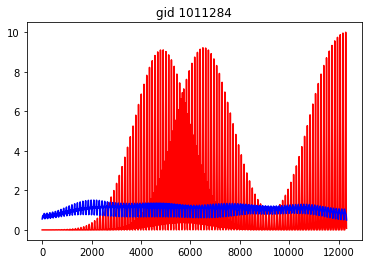

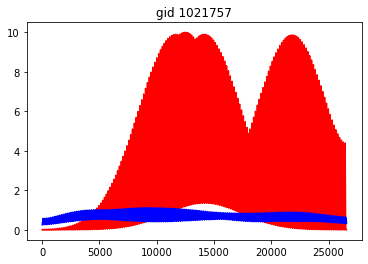

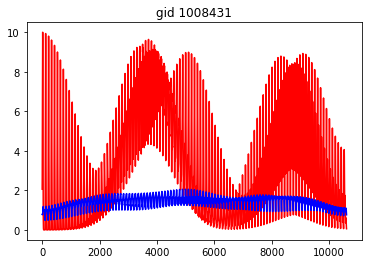

In [11]:
scaled_maps_dict = { gid: get_scaled_input_maps (target_amplitude, structured_weights_dict, gid) 
                   for gid, structured_weights in structured_weights_dict.items() }

for gid, scaled_maps in scaled_maps_dict.items():
    plt.figure()
    plt.title(f"gid {gid}")
    scaled_target_map = scaled_maps['scaled_target_map']
    scaled_initial_map = scaled_maps['scaled_initial_map']
    plt.plot(scaled_target_map, c='r')
    plt.plot(scaled_initial_map, c='b')

In [12]:
from dentate.tntnn import tntnn
lsqr_dict = {}
for gid, scaled_maps in scaled_maps_dict.items():
    scaled_target_map = scaled_maps['scaled_target_map']
    scaled_initial_map = scaled_maps['scaled_initial_map']
    scaled_input_matrix = scaled_maps['scaled_input_matrix']

    lsqr_target_map = scaled_target_map - scaled_initial_map

    res = tntnn(scaled_input_matrix, lsqr_target_map)

    lsqr_delta_weights = np.asarray(res, dtype=np.float32)    
    
    lsqr_dict[gid] = {'lsqr_delta_weights': lsqr_delta_weights,
                       'lsqr_target_map': lsqr_target_map}


B.shape: (12321, 143)
free_set = [142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 125
 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110 109 108 107
 106 105 104 103 102 101 100  99  98  97  96  95  94  93  92  91  90  89
  88  87  86  85  84  83  82  81  80  79  78  77  76  75  74  73  72  71
  70  69  68  67  66  65  64  63  62  61  60  59  58  57  56  55  54  53
  52  51  50  49  48  47  46  45  44  43  42  41  40  39  38  37  36  35
  34  33  32  31  30  29  28  27  26  25  24  23  22  21  20  19  18  17
  16  15  14  13  12  11  10   9   8   7   6   5   4   3   2   1   0]
deletion_set = [142 141 140 139 138 137 136 135 134 133 132 130 128 127 125 124 123 122
 119 118 116 113 112 111 107 106 105 103 102 101  99  98  97  96  95  94
  93  92  91  90  88  87  85  84  83  81  80  79  78  75  73  71  70  68
  67  65  64  63  62  61  60  57  56  55  54  53  52  51  50  49  48  47
  45  44  43  42  40  39  38  37  36  35  34  33  32  30  29  28  27  26
  25  

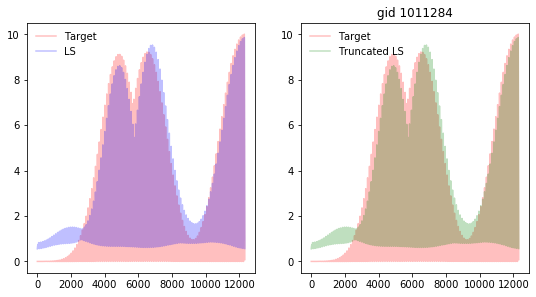

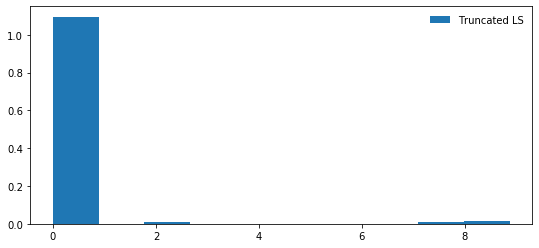

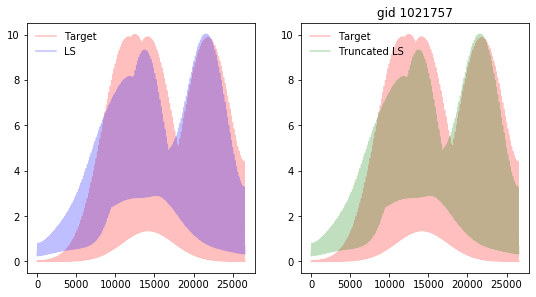

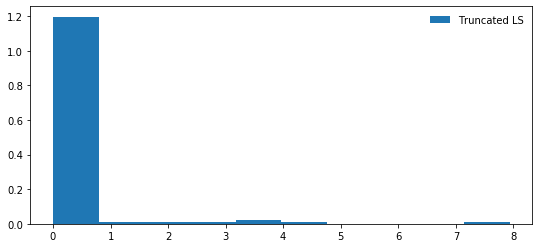

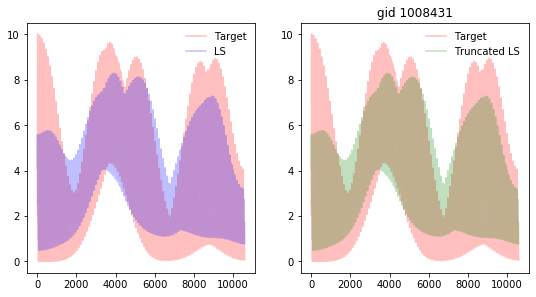

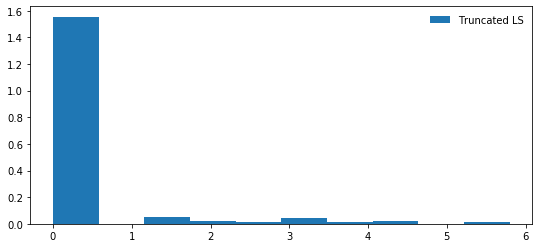

In [13]:
for gid, lsqr_arrays in lsqr_dict.items():
    
    lsqr_delta_weights = lsqr_arrays['lsqr_delta_weights']
    scaled_maps = scaled_maps_dict[gid]
    scaled_target_map = scaled_maps['scaled_target_map']
    scaled_background_map = scaled_maps['scaled_initial_map']
    scaled_input_matrix = scaled_maps['scaled_input_matrix']
    scaled_non_structured_input_matrix = scaled_maps['scaled_non_structured_input_matrix']
    initial_weight_array = scaled_maps['normed_initial_weights']
    non_structured_weight_array = scaled_maps['normed_non_structured_weights']


    lb = 0.
    ub = max_delta_weight
    initial_LS_bounds = (lb, ub)
    initial_LS_delta_weights = np.clip(lsqr_delta_weights, initial_LS_bounds[0], initial_LS_bounds[1])
    lsqr_arrays['initial_LS_delta_weights'] = initial_LS_delta_weights

    lsqr_map = np.dot(scaled_input_matrix, lsqr_delta_weights + initial_weight_array)
    if scaled_non_structured_input_matrix is not None:
        
        lsqr_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)
    initial_LS_map = np.dot(scaled_input_matrix, initial_LS_delta_weights + initial_weight_array)
    if scaled_non_structured_input_matrix is not None:
        initial_LS_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)

    
    fig, axes = plt.subplots(1, 2, figsize=(9., 4.6))
    plt.title(f'gid {gid}')
    axes[0].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[1].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[0].plot(lsqr_map, c='b', alpha=0.25, label='LS')
    axes[1].plot(initial_LS_map, c='g', alpha=0.25, label='Truncated LS')
    axes[0].legend(loc='best', frameon=False, framealpha=0.5)
    axes[1].legend(loc='best', frameon=False, framealpha=0.5)

    plt.figure(figsize=(9,4))
    #plt.xscale('log')
    plt.hist(initial_LS_delta_weights, density=True, label='Truncated LS')
    plt.legend(loc='best', frameon=False, framealpha=0.5)


# Structured weights configuration for GC

In [14]:
destination = 'GC'
sources = ['MPP', 'LPP']
non_structured_sources = ['MC', 'ConMC']  # []


target_gid_set = set([10411, 52479, 125066, 204202, 313753])


In [15]:
input_features_namespaces = ['Place Selectivity', 'Grid Selectivity']
this_input_features_namespaces = ['%s %s' % (input_features_namespace, arena_id) 
                                  for input_features_namespace in input_features_namespaces]

selectivity_type_index = { i: n for n, i in viewitems(env.selectivity_types) }
target_selectivity_type_name = 'place'
target_selectivity_type = env.selectivity_types[target_selectivity_type_name]
features_attrs = defaultdict(dict)
source_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate',
                                  'Module ID', 'Grid Spacing', 'Grid Orientation', 'Field Width Concentration Factor', 
                                  'X Offset', 'Y Offset']
target_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate', 
                                  'X Offset', 'Y Offset']

local_random = np.random.RandomState()

seed_offset = int(env.model_config['Random Seeds']['GC Structured Weights'])
spatial_resolution = env.stimulus_config['Spatial Resolution'] # cm

arena = env.stimulus_config['Arena'][arena_id]
default_run_vel = arena.properties['default run velocity']  # cm/s

gid_count = 0
all_sources = sources + non_structured_sources


In [16]:

connection_gen_list = [ NeuroH5ProjectionGen(connections_path, source, destination, namespaces=['Synapses']) 
                        for source in all_sources ]
field_width = None
peak_rate = None
structured_weights_dict = {}

for iter_count, attr_gen_package in enumerate(zip_longest(*connection_gen_list)):
        
        this_gid = attr_gen_package[0][0]
        
        if not all([attr_gen_items[0] == this_gid for attr_gen_items in attr_gen_package]):
            raise Exception(f'destination: {destination}; gid {this_gid} not matched across multiple attribute '
                            f'generators: {[attr_gen_items[0] for attr_gen_items in attr_gen_package]}')

        if (target_gid_set is not None) and (this_gid not in target_gid_set):
            continue


        if this_gid is None:
            selection = []
            logger.info('received None')
        else:
            selection = [this_gid]
            local_random.seed(int(this_gid + seed_offset))

        has_structured_weights = False

        dst_input_features_attr_dict = {}
        for input_features_namespace in this_input_features_namespaces:
            print(input_features_namespace, destination, selection)
            input_features_iter = read_cell_attribute_selection(input_features_path, destination, 
                                                                namespace=input_features_namespace,
                                                                mask=set(target_features_attr_names), 
                                                                selection=selection)
            count = 0
            for gid, attr_dict in input_features_iter:
                dst_input_features_attr_dict[gid] = attr_dict
                count += 1
            logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {destination}')

        arena_margin = 0.
        target_selectivity_features_dict = {}
        target_selectivity_config_dict = {}
        target_field_width_dict = {}
        for gid in selection:
            target_selectivity_features_dict[gid] = dst_input_features_attr_dict.get(gid, {})
            target_selectivity_features_dict[gid]['Selectivity Type'] = np.asarray([target_selectivity_type], dtype=np.uint8)

            num_fields = target_selectivity_features_dict[gid]['Num Fields'][0]
            
            if coordinates[0] is not None:
                num_fields = 1
                target_selectivity_features_dict[gid]['X Offset'] =  np.asarray([coordinates[0]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Y Offset'] =  np.asarray([coordinates[1]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Num Fields'] = np.asarray([num_fields], dtype=np.uint8)

            if field_width is not None:
                target_selectivity_features_dict[gid]['Field Width'] = np.asarray([field_width]*num_fields, dtype=np.float32)
            else:
                this_field_width = target_selectivity_features_dict[gid]['Field Width']
                target_selectivity_features_dict[gid]['Field Width'] = this_field_width[:num_fields]
                
            if peak_rate is not None:
                target_selectivity_features_dict[gid]['Peak Rate'] = np.asarray([peak_rate]*num_fields, dtype=np.float32)

            input_cell_config = stimulus.get_input_cell_config(target_selectivity_type,
                                                               selectivity_type_index,
                                                               selectivity_attr_dict=target_selectivity_features_dict[gid])
            if input_cell_config.num_fields > 0:
                arena_margin = max(arena_margin, np.max(input_cell_config.field_width) / 2.) if use_arena_margin else 0.
                target_field_width_dict[gid] = input_cell_config.field_width
                target_selectivity_config_dict[gid] = input_cell_config
                has_structured_weights = True

        arena_x, arena_y = stimulus.get_2D_arena_spatial_mesh(arena, spatial_resolution,
                                                              margin=arena_margin)
        for gid, input_cell_config in viewitems(target_selectivity_config_dict):
            target_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y,
                                                                   scale=field_width_scale),
                                    dtype=np.float32)
            target_selectivity_features_dict[gid]['Arena Rate Map'] = target_map

                
        if not has_structured_weights:
            selection = []
                
        initial_weights_by_syn_id_dict = defaultdict(lambda: dict())
        initial_weights_by_source_gid_dict = defaultdict(lambda: dict())
        if initial_weights_path is not None:
            initial_weights_iter = \
              read_cell_attribute_selection(initial_weights_path, destination,
                                            namespace=initial_weights_namespace,
                                            selection=selection)

            initial_weights_gid_count = 0
            for this_gid, syn_weight_attr_dict in initial_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    initial_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                initial_weights_gid_count += 1

            logger.info(f'destination: {destination}; read initial synaptic weights for {initial_weights_gid_count} gids')
            
        if len(non_structured_sources) > 0:
            non_structured_weights_by_syn_id_dict = defaultdict(lambda: dict())
            non_structured_weights_by_source_gid_dict = defaultdict(lambda: dict())
        else:
            non_structured_weights_by_syn_id_dict = None
            
        if non_structured_weights_path is not None:
            non_structured_weights_iter = \
                read_cell_attribute_selection(initial_weights_path, destination,
                                              namespace=non_structured_weights_namespace,
                                              selection=selection)

            non_structured_weights_gid_count = 0
            non_structured_weights_syn_count = 0
            for this_gid, syn_weight_attr_dict in non_structured_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    non_structured_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                non_structured_weights_gid_count += 1
                non_structured_weights_syn_count += len(syn_ids)     

        syn_count_by_source_gid_dict = defaultdict(int)
        source_gid_set_dict = defaultdict(set)
        syn_ids_by_source_gid_dict = defaultdict(list)
        structured_syn_id_count = 0

        if has_structured_weights:
            for source, (destination_gid, (source_gid_array, conn_attr_dict)) in zip_longest(all_sources, attr_gen_package):
                syn_ids = conn_attr_dict['Synapses']['syn_id']
                count = 0
                this_initial_weights_by_syn_id_dict = None
                this_initial_weights_by_source_gid_dict = None
                this_non_structured_weights_by_syn_id_dict = None
                this_non_structured_weights_by_source_gid_dict = None
                
                if destination_gid is not None:
                    this_initial_weights_by_syn_id_dict = initial_weights_by_syn_id_dict[destination_gid]
                    this_initial_weights_by_source_gid_dict = initial_weights_by_source_gid_dict[destination_gid]
                    this_non_structured_weights_by_syn_id_dict = non_structured_weights_by_syn_id_dict[destination_gid]
                    this_non_structured_weights_by_source_gid_dict = non_structured_weights_by_source_gid_dict[destination_gid]


                for i in range(len(source_gid_array)):
                    this_source_gid = source_gid_array[i]
                    this_syn_id = syn_ids[i]
                    if this_syn_id in this_initial_weights_by_syn_id_dict:
                        this_syn_wgt = this_initial_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_initial_weights_by_source_gid_dict:
                            this_initial_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                        
                    elif this_syn_id in this_non_structured_weights_by_syn_id_dict:
                        this_syn_wgt = this_non_structured_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_non_structured_weights_by_source_gid_dict:
                            this_non_structured_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                    source_gid_set_dict[source].add(this_source_gid)
                    syn_ids_by_source_gid_dict[this_source_gid].append(this_syn_id)
                    syn_count_by_source_gid_dict[this_source_gid] += 1
                    
                    count += 1
                if source not in non_structured_sources:
                    structured_syn_id_count += len(syn_ids)
                logger.info(f'destination: {destination}; gid {this_gid}; {count} edges from source population {source}')



        input_rate_maps_by_source_gid_dict = {}
        if len(non_structured_sources) > 0:
            non_structured_input_rate_maps_by_source_gid_dict = {}
        else:
            non_structured_input_rate_maps_by_source_gid_dict = None
        for source in all_sources:
            if has_structured_weights:
                source_gids = list(source_gid_set_dict[source])
            else:
                source_gids = []
            logger.info(f'Reading {input_features_namespace} feature data for {len(source_gids)} cells in population {source}...')
            for input_features_namespace in this_input_features_namespaces:
                input_features_iter = read_cell_attribute_selection(input_features_path, source, 
                                                                    namespace=input_features_namespace,
                                                                    mask=set(source_features_attr_names), 
                                                                    comm=env.comm, selection=source_gids)
                count = 0
                for gid, attr_dict in input_features_iter:
                    this_selectivity_type = attr_dict['Selectivity Type'][0]
                    this_selectivity_type_name = selectivity_type_index[this_selectivity_type]
                    input_cell_config = stimulus.get_input_cell_config(this_selectivity_type,
                                                                       selectivity_type_index,
                                                                       selectivity_attr_dict=attr_dict)
                    this_arena_rate_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y),
                                                     dtype=np.float32)
                    if source in non_structured_sources:
                        non_structured_input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    else:
                        input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    count += 1
                
                logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {source}')

        if has_structured_weights:

            structured_weights_dict[this_gid] = \
                {'target_map': target_selectivity_features_dict[this_gid]['Arena Rate Map'],
                 'initial_weight_dict': initial_weights_by_source_gid_dict[this_gid],
                 'non_structured_weight_dict': non_structured_weights_by_source_gid_dict[this_gid],
                 'input_rate_map_dict': input_rate_maps_by_source_gid_dict,
                 'non_structured_input_rate_map_dict': non_structured_input_rate_maps_by_source_gid_dict,
                 'syn_count_dict': syn_count_by_source_gid_dict,
                 'max_delta_weight': max_delta_weight, 
                 'arena_x': arena_x, 
                 'arena_y': arena_y
                }



Place Selectivity A GC [313753]
Grid Selectivity A GC [313753]
Place Selectivity A GC [125066]
Grid Selectivity A GC [125066]
Place Selectivity A GC [204202]
Grid Selectivity A GC [204202]
Place Selectivity A GC [10411]
Grid Selectivity A GC [10411]
Place Selectivity A GC [52479]
Grid Selectivity A GC [52479]


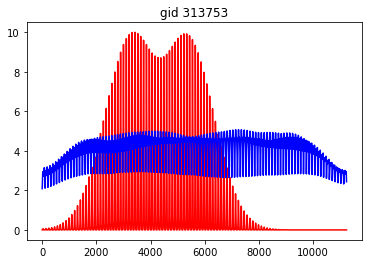

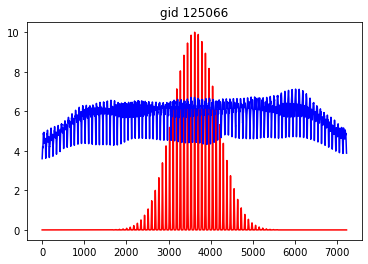

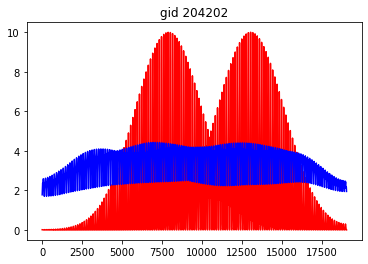

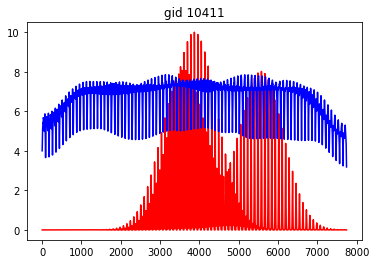

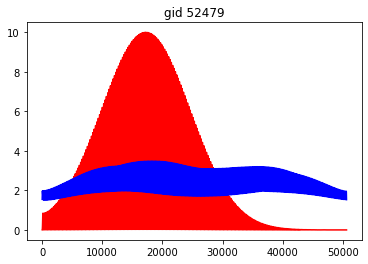

In [17]:
scaled_maps_dict = { gid: get_scaled_input_maps (target_amplitude, structured_weights_dict, gid) 
                   for gid, structured_weights in structured_weights_dict.items() }

for gid, scaled_maps in scaled_maps_dict.items():
    plt.figure()
    plt.title(f"gid {gid}")
    scaled_target_map = scaled_maps['scaled_target_map']
    scaled_initial_map = scaled_maps['scaled_initial_map']
    plt.plot(scaled_target_map, c='r')
    plt.plot(scaled_initial_map, c='b')

In [18]:
lsqr_dict = {}
for gid, scaled_maps in scaled_maps_dict.items():
    scaled_target_map = scaled_maps['scaled_target_map']
    scaled_initial_map = scaled_maps['scaled_initial_map']
    scaled_input_matrix = scaled_maps['scaled_input_matrix']

    lsqr_target_map = scaled_target_map - scaled_initial_map

    res = tntnn(scaled_input_matrix, lsqr_target_map, rel_tol=1e-4)

    lsqr_delta_weights = np.asarray(res, dtype=np.float32)    
    
    lsqr_dict[gid] = {'lsqr_delta_weights': lsqr_delta_weights,
                       'lsqr_target_map': lsqr_target_map}


B.shape: (11236, 2126)
free_set = [2125 2124 2123 ...    2    1    0]
deletion_set = [2122 2119 2117 ...    3    2    0]
B.shape: (11236, 541)
free_set = [2124 2117 2115 2109 2107 2093 2092 2091 2085 2082 2077 2071 2068 2063
 2060 2055 2053 2052 2049 2046 2043 2038 2037 2036 2031 2030 2027 2025
 2019 2009 2008 2001 1993 1989 1988 1986 1985 1980 1979 1978 1970 1968
 1967 1966 1962 1959 1958 1954 1947 1946 1938 1934 1929 1926 1925 1922
 1919 1910 1907 1905 1900 1895 1893 1891 1885 1883 1879 1877 1876 1872
 1869 1864 1858 1855 1850 1848 1838 1835 1830 1821 1813 1812 1804 1801
 1799 1796 1785 1781 1779 1778 1773 1772 1771 1768 1762 1761 1759 1757
 1751 1749 1746 1745 1743 1742 1741 1739 1737 1736 1734 1728 1719 1710
 1699 1695 1694 1691 1689 1688 1680 1679 1678 1675 1672 1671 1669 1667
 1661 1660 1647 1641 1640 1639 1635 1631 1627 1620 1618 1617 1615 1609
 1607 1605 1604 1601 1600 1595 1591 1585 1576 1575 1573 1571 1570 1568
 1564 1561 1554 1552 1541 1538 1536 1534 1530 1526 1523 1514 1513

ValueError: shape mismatch: value array of shape (4,)  could not be broadcast to indexing result of shape (0,)